In [1]:
%pip install davos
import davos

%conda install pytables

davos.config.suppress_stdout = True

Note: you may need to restart the kernel to use updated packages.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [176]:
smuggle nltools as nlt            # pip: nltools==0.4.7

smuggle nilearn as nl             # pip: nilearn==0.10.0
smuggle nibabel as nib            # pip: nibabel==5.0.1

smuggle datawrangler as dw        # pip: pydata-wrangler==0.2.2

smuggle numpy as np               # pip: numpy==1.24.2
smuggle matplotlib.pyplot as plt  # pip: matplotlib==3.7.0
from matplotlib.colors smuggle ListedColormap
from matplotlib.ticker import FormatStrFormatter

smuggle pandas as pd              # pip: pandas==1.5.3
smuggle seaborn as sns            # pip: seaborn==0.12.2
from skimage smuggle transform    # pip: scikit-image==0.20.0

from sklearn.decomposition smuggle IncrementalPCA as PCA  # pip: scikit-learn==1.2.1
from scipy.spatial.distance smuggle cdist                 # pip: scipy==1.10.1
from scipy.io smuggle loadmat
from scipy.stats smuggle spearmanr
from tqdm smuggle tqdm            # pip: tqdm==4.64.1

smuggle requests                  # pip: requests==2.28.2

from datetime import datetime as dt
import os
import shutil
import pickle
import warnings
from glob import glob as lsdir

from helpers import nii2cmu, cmu2nii, conditions, condition_colors, figdir, basedir, datadir, scratch_dir, group_pca, get_data, rbf

Fetch/load the HTFA posterior

In [3]:
data = get_data()

Load a neurosynth topic map to use as a template

In [4]:
neurosynth_dir = os.path.join(datadir, 'neurosynth')
nii_fname = os.path.join(neurosynth_dir, 'topic0_pFgA_z.nii.gz')
template = nii2cmu(nii_fname)

Compute the HTFA factor images matrix:
  - Rows: factors
  - Columns: voxels in the template brain

In [5]:
factors = []
for c, w in zip(data['centers'], data['widths']):
    factors.append(np.atleast_2d(rbf(template['R'], c, w)).T)

F = np.hstack(factors).T

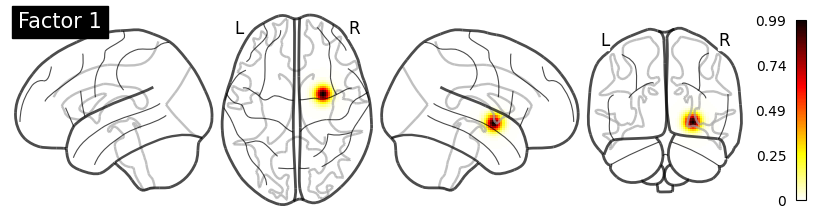

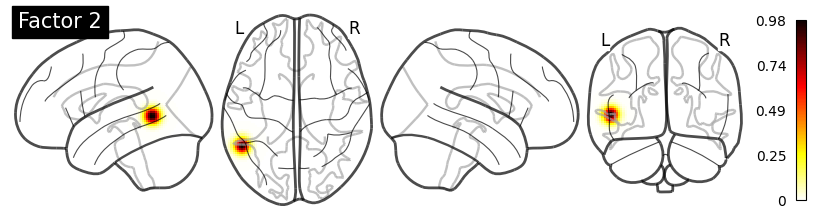

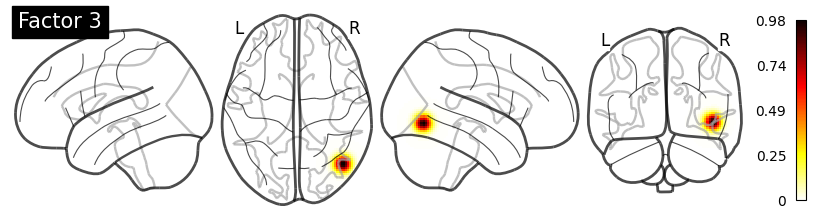

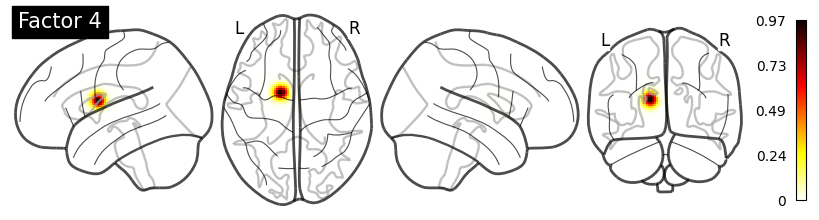

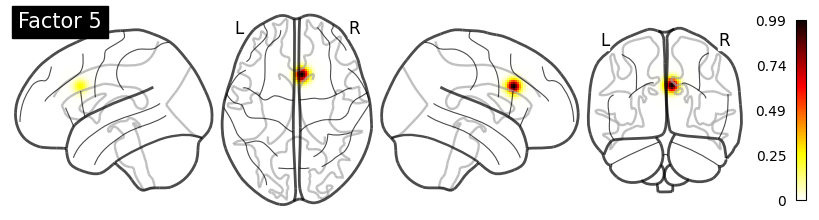

In [6]:
# plot some sample factors

for i in range(5):
    nl.plotting.plot_glass_brain(cmu2nii(F[i, :], template['R'], nii_fname), colorbar=True, title=f'Factor {i+1}', display_mode='lzry', figure=plt.figure(figsize=(8, 2)))

Compress each condition using group PCA

In [7]:
# number of components to plot/decode
k = 5

components = {}
for c in conditions:
    _, model = group_pca(data['weights'][c], n_components=k)
    X = model.components_
    components[c] = [cmu2nii(np.dot(np.atleast_2d(X[i, :]), F), template['R'], nii_fname) for i in range(k)]

Plot the component images

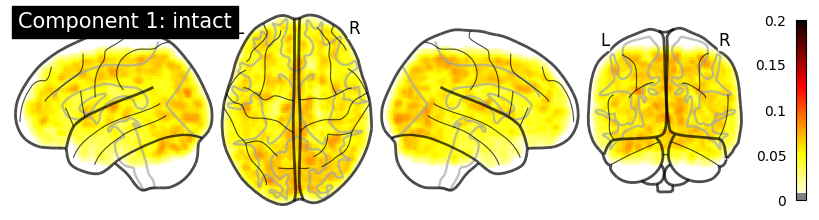

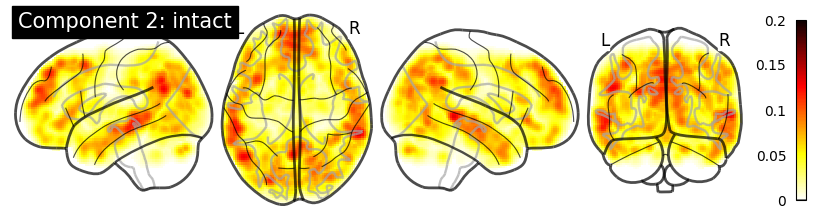

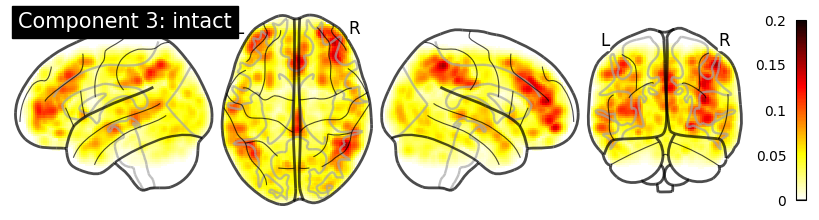

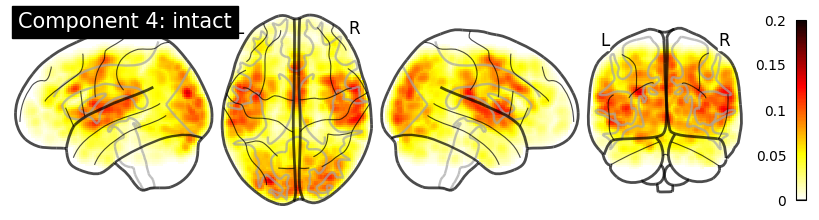

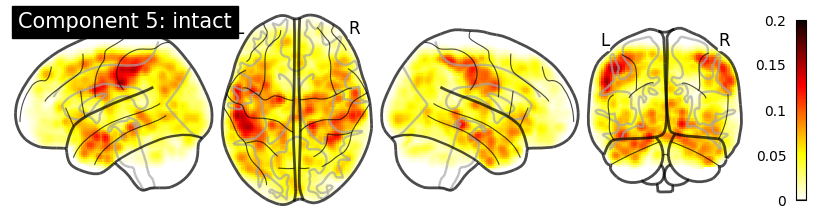

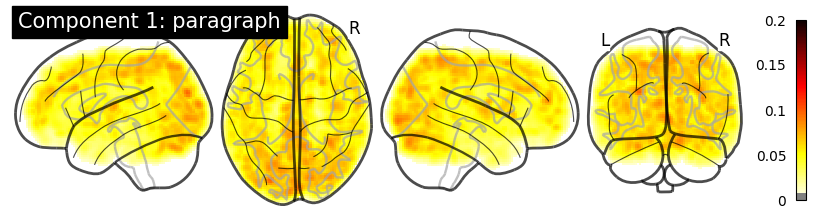

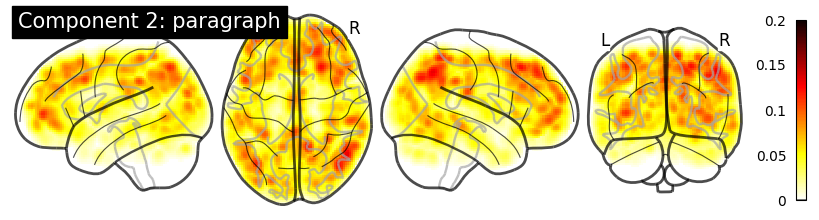

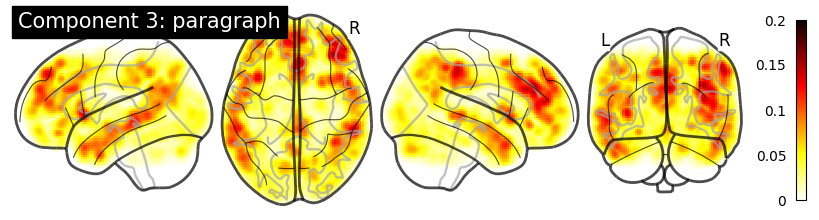

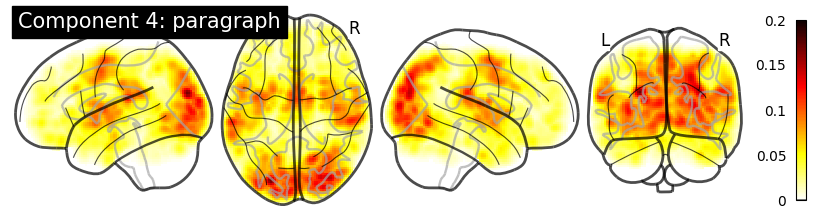

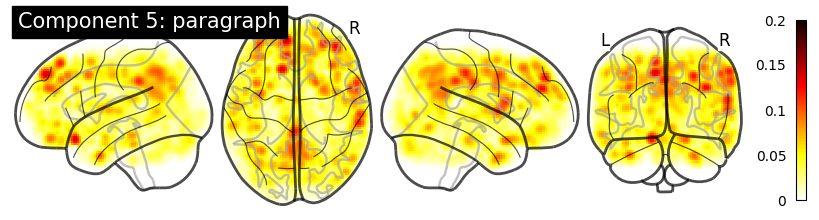

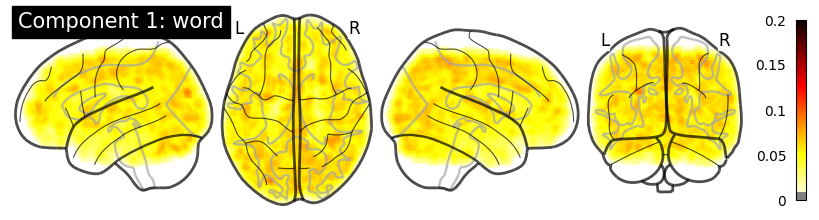

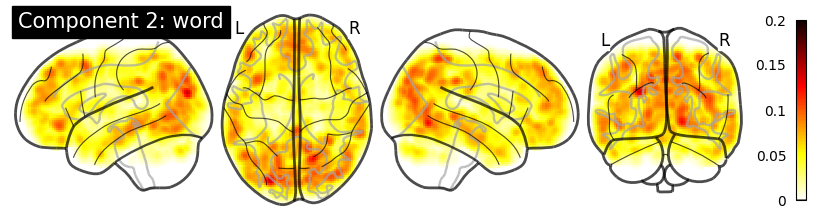

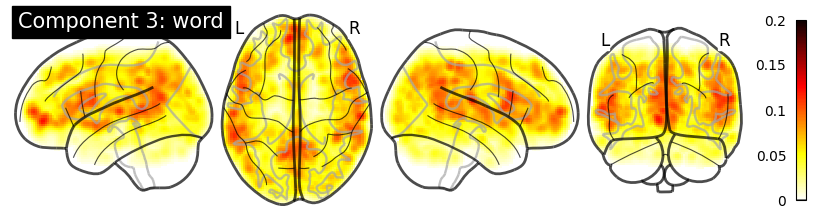

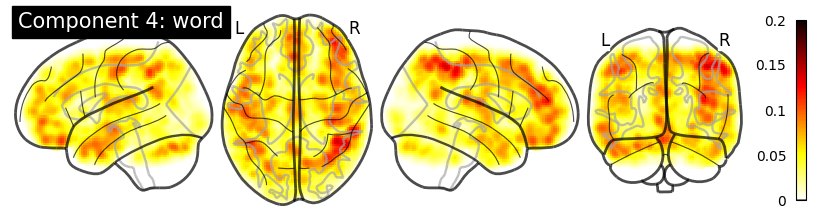

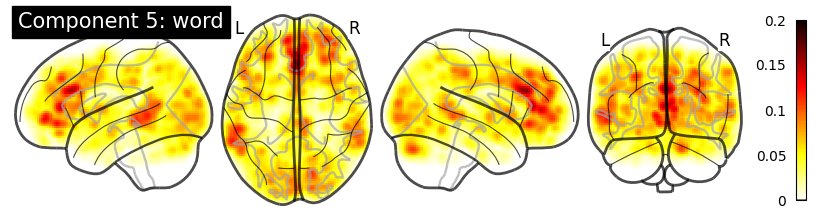

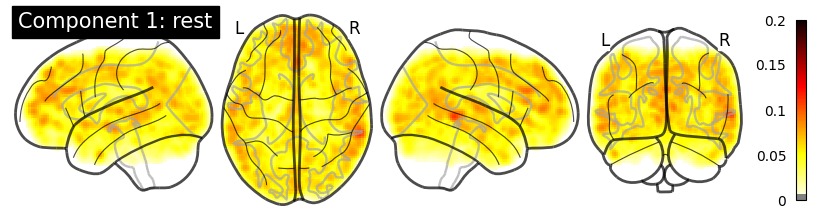

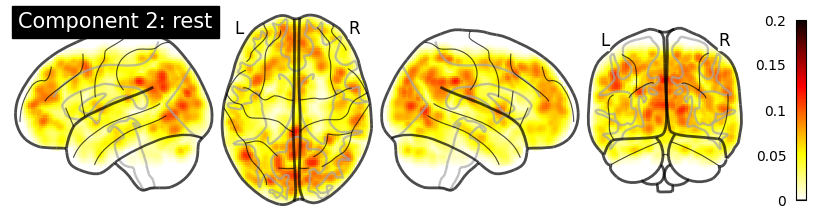

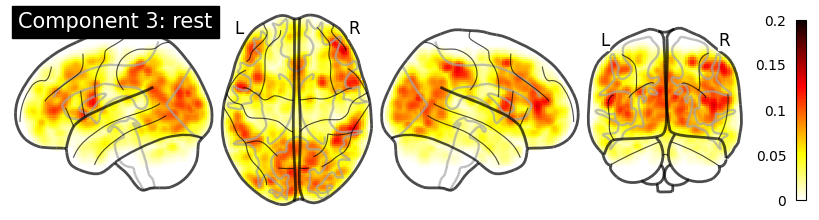

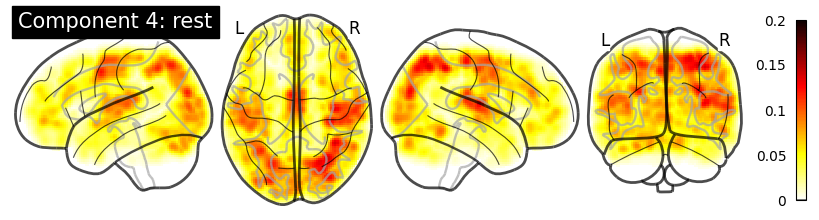

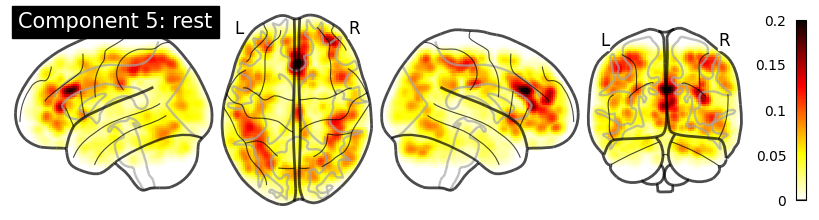

In [156]:
for c in conditions:
    for i in range(k):
        # plot the full component
        nl.plotting.plot_glass_brain(components[c][i], colorbar=True, vmin=0, vmax=0.2, display_mode='lzry', figure=plt.figure(figsize=(8, 2)), output_file=os.path.join(figdir, f'component_{c}_{i+1}_full.pdf'))

        # plot a compact view of the component
        nl.plotting.plot_glass_brain(components[c][i], colorbar=True, vmin=0, vmax=0.2, display_mode='r', figure=plt.figure(figsize=(2, 1)), output_file=os.path.join(figdir, f'component_{c}_{i+1}_sagittal_r.pdf'))

        # display the component (with title) in the notebook
        nl.plotting.plot_glass_brain(components[c][i], colorbar=True, vmin=0, vmax=0.2, title=f'Component {i+1}: {c}', display_mode='lzry', figure=plt.figure(figsize=(8, 2)))

Neurosynth decoding

References:

1. Fox AS, Chang LJ, Gorgolewski KJ, Yarkoni T (2014) [Bridging psychology and genetics using large-scale spatial analysis of neuroimaging and neurogenetic data](https://www.biorxiv.org/content/10.1101/012310v1.abstract).  bioRxiv: doi.org/10.1101/012310

2. Sul S, Güroğlu B, Crone EA, Chang LJ (2017) [Medial prefrontal cortical thinning mediates shifts in other-regarding preferences during adolescence](https://www.nature.com/articles/s41598-017-08692-6.epdf?shared_access_token=axJA9l5exJBRRof-RbTwv9RgN0jAjWel9jnR3ZoTv0N5WG5h1jAaEDJCl6rCzAwqd-CrMFv4PhRKQOqdWcanXG1L9xI9ib0fpcZhug9nV9o7YHzsZYGg3z7ryrmh_WnnAsc0F9znsZb5nvUtDHpgoorMLCs8C0l4JJLYHDy4IV0%3D).  Scientific Reports, 7(8510): doi.org/10.1038/s41598-017-08692-6

3. Chen P-HA, Jolly E, Cheong JH, Chang LJ (2020) [Intersubject representational similarity analysis reveals individual
variations in affective experience when watching erotic movies](http://cosanlab.com/static/papers/Chen_2020_Neuroimage.pdf).  NeuroImage, 216(116851): doi.org/10.1016/j.neuroimage.2020.116851

In [138]:
topics = pd.read_csv(os.path.join(neurosynth_dir, 'topics.csv')).drop('Topic Number', axis=1).drop(['Classification', 'Manual Label'], axis=1).rename({'ChatGPT Label': 'Topic Label'}, axis=1)
topics

Topic Label  Mean doc. weight  \
0              Cognitive control and task performance            0.3172   
1                  Developmental aging and maturation            0.0502   
2                  Eye movements and visual attention            0.0170   
3                        Facial and voice recognition            0.0182   
4          Social interaction and contextual behavior            0.0169   
..                                                ...               ...   
75                     Speech and language processing            0.0317   
76  Network interactions and evidence in human sys...            0.3351   
77                            Neuroimaging techniques            0.1013   
78               Visual perception of motion and form            0.0349   
79                Emotional processing and regulation            0.0708   

         Term 1    Term 2      Term 3       Term 4       Term 5  \
0         tasks   control     network   conditions   comparison   
1           age    adults    children  development  adolescents   
2           eye      gaze        eyes       visual     saccades   
3   recognition  familiar    identity   unfamiliar        voice   
4       context      game       human  interaction          ppi   
..          ...       ...         ...          ...          ...   
75       speech  language    auditory   production   perception   
76      network  evidence       human      systems      support   
77     standard    images  individual         time        image   
78       motion    visual  perception   perceptual   biological   
79    emotional   emotion     neutral       facial  expressions   

           Term 6         Term 7       Term 8  ...      Term 11      Term 12  \
0       performed         common   correlates  ...       active     relative   
1           aging  developmental  adolescence  ...         aged   maturation   
2       movements        saccade    direction  ...     fixation       guided   
3     familiarity          route       voices  ...          atl       famous   
4      contextual       contexts       agency  ...  cooperation     behavior   
..            ...            ...          ...  ...          ...          ...   
75  comprehension      listening     acoustic  ...       sounds       native   
76        process       distinct  integration  ...         role  distributed   
77          voxel        spatial         test  ...  sensitivity          spm   
78        dynamic         moving        human  ...     stimulus         psts   
79      affective      responses     negative  ...     pictures      fearful   

                Term 13     Term 14         Term 15      Term 16      Term 17  \
0            underlying    distinct      substrates    cognitive   performing   
1             adulthood     elderly         reduced   adolescent         ages   
2               pursuit  oculomotor        movement      walking     saccadic   
3                person       names      perception       people   expression   
4   psychophysiological         avh           trust     partners       played   
..                  ...         ...             ...          ...          ...   
75           bilinguals      spoken        speakers    languages     prosodic   
76           perceptual      domain         current   underlying  interaction   
77                space         roi        measures      provide  reliability   
78            direction   sensitive  discrimination         cues         form   
79                happy        fear         disgust  emotionally   perception   

           Term 18         Term 19    Term 20  
0          process           shown   addition  
1             late      developing      range  
2          control          closed     direct  
3   discrimination      personally  condition  
4         computer         virtual     online  
..             ...             ...        ...  
75           voice        phonetic    speaker  
76    interactions

Load in topic maps

In [139]:
topic_maps = [nii2cmu(os.path.join(neurosynth_dir, f'topic{i}_pFgA_z.nii.gz')) for i in topics.index.values]

Display some example maps

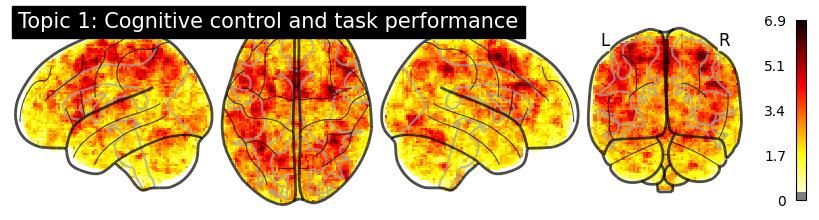

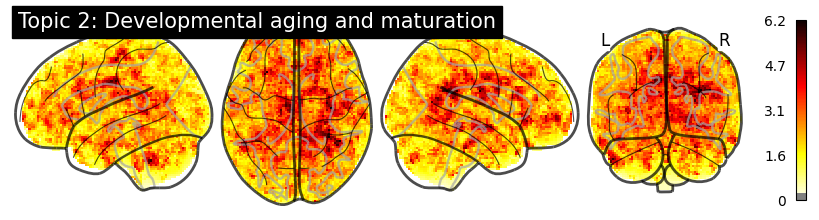

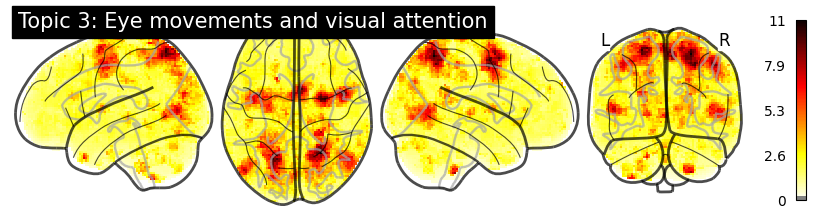

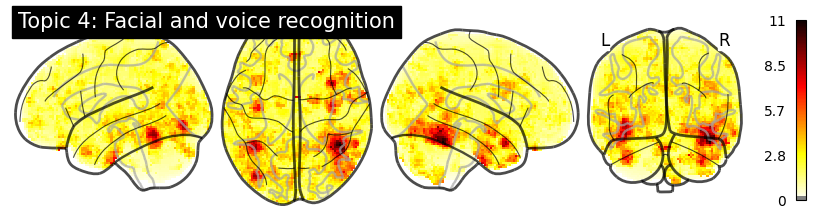

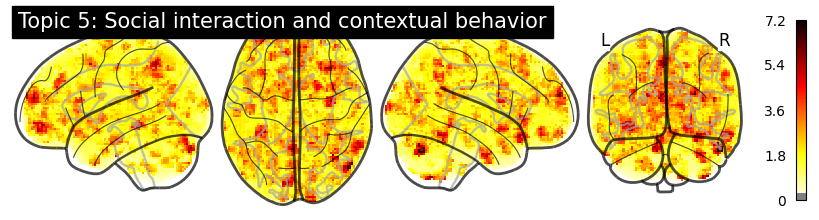

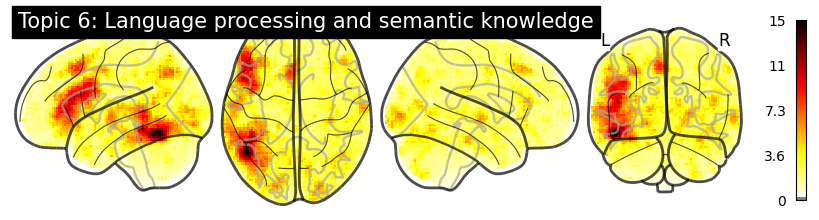

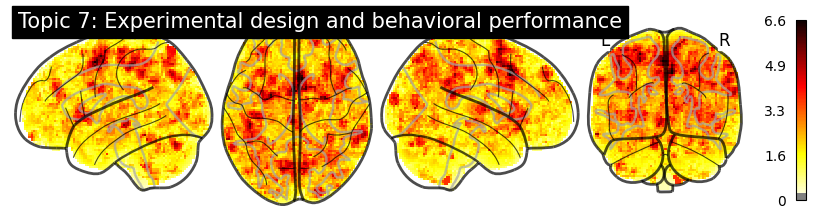

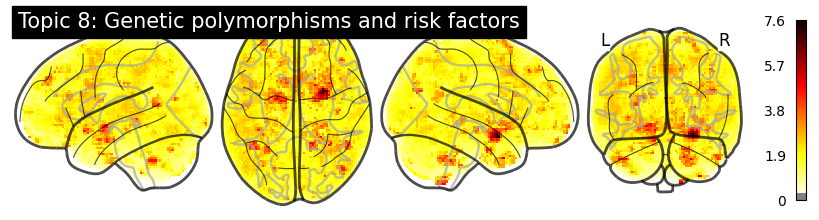

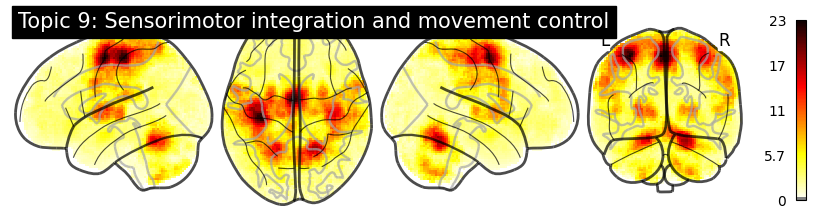

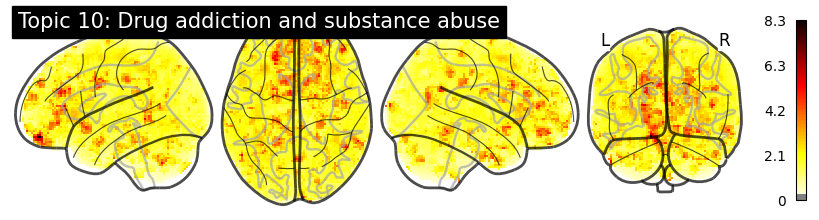

In [191]:
for i, topic in enumerate(topics.index.values[:10]):
    nl.plotting.plot_glass_brain(cmu2nii(topic_maps[i]['Y'], template['R'], nii_fname), colorbar=True, title=f'Topic {topic+1}: {topics.loc[topic]["Topic Label"]}', display_mode='lzry', figure=plt.figure(figsize=(8, 2)))

Convert component maps to CMU format

In [141]:
cmu_components = {}
for c in conditions:
    cmu_components[c] = [nii2cmu(x) for x in components[c]]

Use decoding procedure from [Sul et al. (2017)](https://www.nature.com/articles/s41598-017-08692-6.epdf?shared_access_token=axJA9l5exJBRRof-RbTwv9RgN0jAjWel9jnR3ZoTv0N5WG5h1jAaEDJCl6rCzAwqd-CrMFv4PhRKQOqdWcanXG1L9xI9ib0fpcZhug9nV9o7YHzsZYGg3z7ryrmh_WnnAsc0F9znsZb5nvUtDHpgoorMLCs8C0l4JJLYHDy4IV0%3D) to estimate topic weights from maps for each component and condition

In [142]:
def topic_weights(Y):
    x = np.array([np.corrcoef(topic_maps[i]['Y'], Y)[0, 1] for i in range(len(topic_maps))])
    return x / np.max(np.abs(x))
    

In [143]:
df = []
for c in conditions:
    for i in tqdm(range(k)):
        weights = topic_weights(cmu_components[c][i]['Y'])

        for j in range(len(topic_maps)):
            x = pd.Series(dtype=object)
            x['Condition'] = c
            x['Component'] = i+1
            x['Topic'] = topics.iloc[j]['Topic Label']
            x['Weight'] = weights[j]
            df.append(pd.DataFrame(x).T)

df = pd.concat(df, ignore_index=True)
df['Weight'] = df['Weight'].astype(float)

100%|██████████| 5/5 [00:00<00:00,  5.77it/s]


In [150]:
df

Condition Component                                              Topic  \
0       intact         1             Cognitive control and task performance   
1       intact         1                 Developmental aging and maturation   
2       intact         1                 Eye movements and visual attention   
3       intact         1                       Facial and voice recognition   
4       intact         1         Social interaction and contextual behavior   
...        ...       ...                                                ...   
1595      rest         5                     Speech and language processing   
1596      rest         5  Network interactions and evidence in human sys...   
1597      rest         5                            Neuroimaging techniques   
1598      rest         5               Visual perception of motion and form   
1599      rest         5                Emotional processing and regulation   

        Weight  
0     0.606619  
1    -0.131594  
2     0.039396  
3     0.178475  
4     0.071619  
...        ...  
1595 -0.440286  
1596 -0.462274  
1597  0.342811  
1598 -0.585449  
1599  0.488488  

[1600 rows x 4 columns]

In [162]:
def format(s, target=10):
    s = str(s).split()
    y = []
    next = ''
    appended = False
    for i in range(len(s)):
        if len(next) + len(s[i]) + 1 > target:
            y.append(next)
            next = s[i]
        else:
            next += ' ' + s[i]
    
    if next != '':
        y.append(next)
    
    return '\n'.join(y)

In [185]:
def spider_plot(x, xcol, ycol, hue=None, limit=None, axfontsize=10, ax=None, colors=None, alpha=0.1, legend=False, pad=25, width=5, height=5, fname=None, **kwargs):
    if ax is None:
        fig = plt.figure(figsize=(width, height))
        ax = plt.subplot(111, polar=True)

    if limit is not None:
        if hue is not None:
            x = x.groupby(hue).apply(lambda x: x.nlargest(limit, ycol)).reset_index(drop=True)
        else:
            x = x.nlargest(limit, ycol)

    unique_xvals = x[xcol].unique()
    unique_yvals = x[ycol].unique()

    angles = [n / float(len(unique_xvals)) * 2 * np.pi for n in range(len(unique_xvals))]
    angles += angles[:1]

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([format(s) for s in unique_xvals], fontsize=axfontsize)
    ax.tick_params(axis='x', pad=pad)

    ax.set_rlabel_position(90)    
    #ax.set_yticks([np.min(unique_yvals), np.max(unique_yvals)])
    #ax.set_yticklabels([np.min(unique_yvals), np.max(unique_yvals)], fontsize=axfontsize)

    if hue is not None:
        unique_hues = x[hue].unique()
        if colors is None:    
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                colors = get_cmap('viridis', len(unique_hues))
                colors = [colors(i) for i in range(len(unique_hues))]
        elif type(colors) == dict:
            colors = [colors[h] for h in unique_hues]

        for i, h in enumerate(unique_hues):
            xh = x[x[hue] == h]

            next_angles = [angles[np.where(unique_xvals == v)[0][0]] for v in xh[xcol].values.tolist()]
            order = np.argsort(next_angles)
            
            next_angles = np.array(next_angles)[order].tolist()
            next_angles += next_angles[:1]

            values = xh[ycol].values[order].tolist()
            values += values[:1]
            ax.fill(next_angles, values, alpha=alpha, color=colors[i])
            ax.plot(next_angles, values, linestyle='solid', label=h, color=colors[i], **kwargs)
        
        if legend:
            ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=axfontsize)
    else:
        if colors is None:
            colors = ['k']        
        elif type(colors) == str:
            colors = [colors]            
        values = x[ycol].values.tolist()
        values += values[:1]
        ax.plot(angles, values, linestyle='solid', color=colors[0], **kwargs)

    ax.set_yticks(ax.get_yticks()[:-2:2])
    ax.tick_params(axis='both', which='major', labelsize=axfontsize)

    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')
    
    return fig

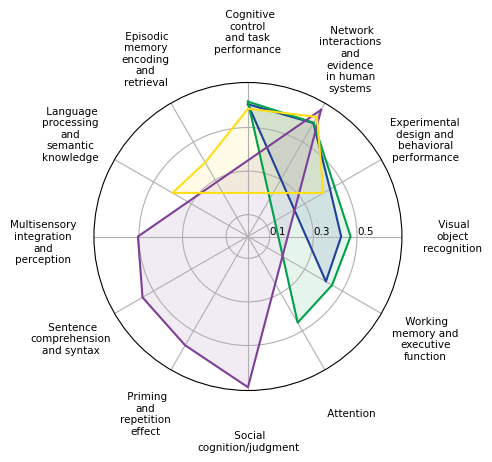

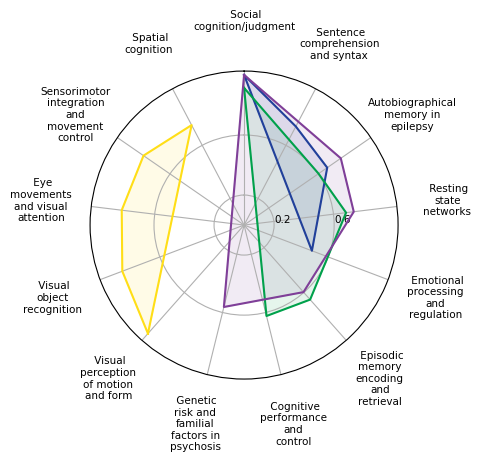

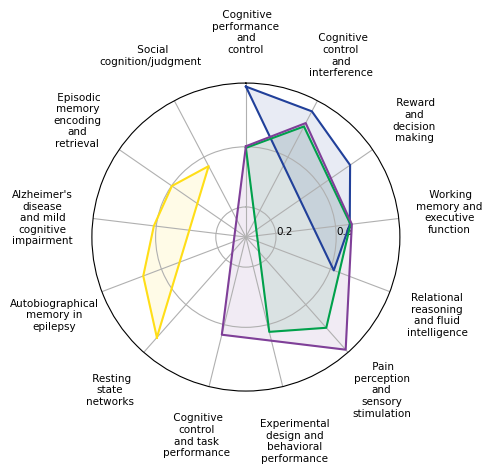

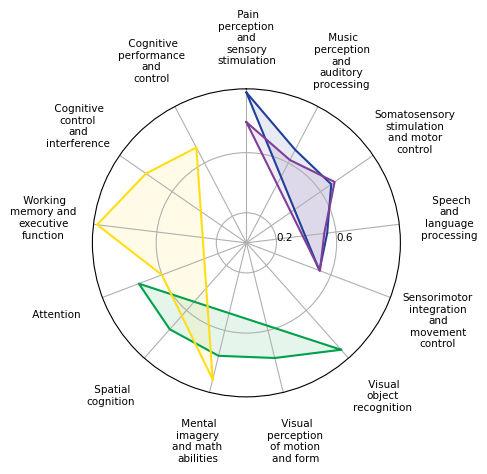

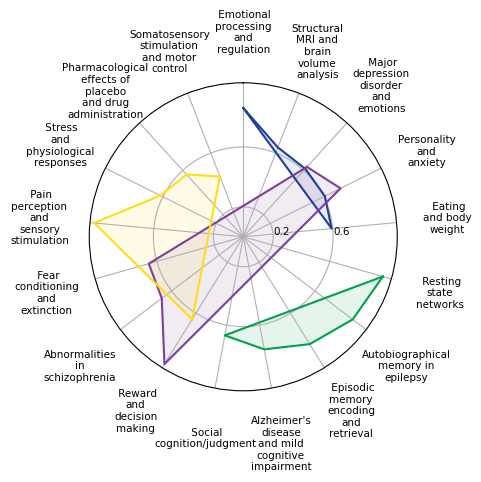

In [186]:
for i in df['Component'].unique():
    spider_plot(df[df['Component'] == i], 'Topic', 'Weight', hue='Condition', colors=condition_colors,
                limit=5, width=4, height=4, axfontsize=7.5, pad=26 ,legend=False, fname=f'spider_plot_component_{i}')

Average weighting across top $k$ components...

In [187]:
mdf = df.groupby(['Condition', 'Topic']).mean(numeric_only=True).reset_index()
mdf

Condition                                      Topic    Weight
0      intact                ADHD and attention deficits  0.094286
1      intact             Abnormalities in schizophrenia  0.095872
2      intact    Abstract categories and representations -0.135723
3      intact           Action observation and imitation -0.307421
4      intact  Affective valence and feedback processing  0.197278
..        ...                                        ...       ...
315      word                  Tinnitus and hearing loss -0.047307
316      word                  Visual object recognition  0.231174
317      word       Visual perception of motion and form  0.147861
318      word        Working memory and error monitoring  0.135034
319      word      Working memory and executive function  0.235553

[320 rows x 3 columns]

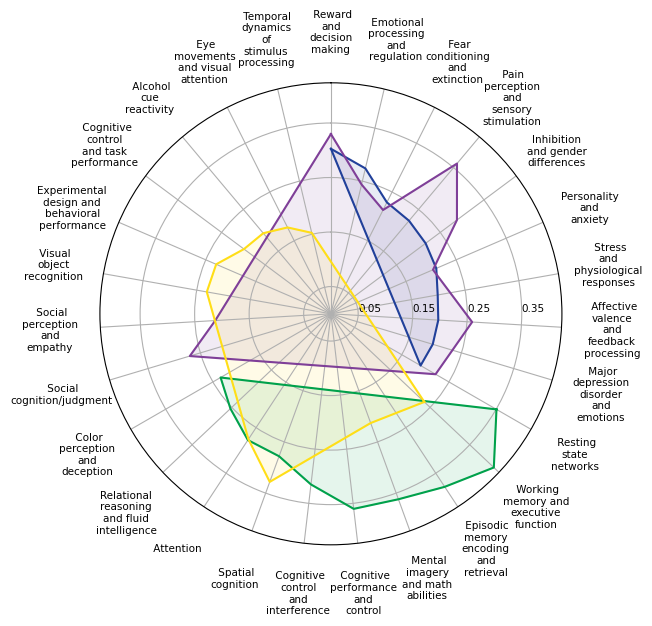

In [190]:
spider_plot(mdf, 'Topic', 'Weight', hue='Condition', colors=condition_colors, limit=10, width=6, height=6, axfontsize=7.5, pad=26, legend=False, fname='spider_plot_mean');